In [1]:
import os
import random
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import pandas as pd
from sktime.datasets import load_from_arff_to_dataframe

In [2]:
def combine_and_translate_classes(train_x: pd.DataFrame, train_y: np.array, class_labels: dict, classes_category: str) -> pd.DataFrame:
    y_dataframe = pd.DataFrame(data = train_y, columns=[classes_category])
    combined_data_frame =  pd.merge(train_x, y_dataframe, left_index=True, right_index=True, )
    for class_label_key in class_labels:
        class_label_value = class_labels[class_label_key]
        combined_data_frame.loc[combined_data_frame[classes_category] == class_label_key, classes_category] = class_label_value

    return combined_data_frame

In [3]:
PEMS_SF_DATA_PATH = "./PEMS-SF"
PEMS_SF_CLASSES_CATEGORY = "Day of the week"
PEMS_SF_CLASS_VALUES_MAPPER = {
    "1.0" : "Monday",
    "2.0" : "Tuesday",
    "3.0" : "Wednesday",
    "4.0" : "Thursday",
    "5.0" : "Friday",
    "6.0" : "Saturday",
    "7.0" : "Sunday",
}

train_x_pems_sf, train_y_pems_sf = load_from_arff_to_dataframe(
    os.path.join(PEMS_SF_DATA_PATH, "PEMS-SF_TRAIN.arff")
)
test_x_pems_sf, test_y_pems_sf = load_from_arff_to_dataframe(
    os.path.join(PEMS_SF_DATA_PATH, "PEMS-SF_TEST.arff")
)

pems_sf_columns = train_x_pems_sf.columns
pems_sf_train_translated = combine_and_translate_classes(\
    train_x_pems_sf, train_y_pems_sf, PEMS_SF_CLASS_VALUES_MAPPER, PEMS_SF_CLASSES_CATEGORY)

/home/samanu/.local/lib/python3.8/site-packages/sktime/datasets/_data_io.py:1108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_data["dim_" + str(dim)] = instance_list[dim]


In [4]:
U_WAVE_GESTURE_DATA_PATH = "./UWaveGestureLibrary"
U_WAVE_CLASSES_CATEGORY = "Gesture"
U_WAVE_GESTURE_CLASS_VALUES_MAPPER = {
    "1.0" : "Gesture 1",
    "2.0" : "Gesture 2",
    "3.0" : "Gesture 3",
    "4.0" : "Gesture 4",
    "5.0" : "Gesture 5",
    "6.0" : "Gesture 6",
    "7.0" : "Gesture 7",
    "8.0" : "Gesture 8",
}

U_WAVE_GESTURE_CLASS_VALUES_TO_COLOR_MAPPER = {
    "Gesture 1" : "red",
    "Gesture 2" : "green",
    "Gesture 3" : "blue",
    "Gesture 4" : "yellow",
    "Gesture 5" : "brown",
    "Gesture 6" : "black",
    "Gesture 7" : "grey",
    "Gesture 8" : "orange",
}


train_x_u_wave_gesture, train_y_u_wave_gesture = load_from_arff_to_dataframe(
    os.path.join(U_WAVE_GESTURE_DATA_PATH, "UWaveGestureLibrary_TRAIN.arff")
)
test_x_u_wave_gesture, test_y_u_wave_gesture = load_from_arff_to_dataframe(
    os.path.join(U_WAVE_GESTURE_DATA_PATH, "UWaveGestureLibrary_TEST.arff")
)

u_wave_gesture_train_translated = combine_and_translate_classes(\
    train_x_u_wave_gesture, train_y_u_wave_gesture, U_WAVE_GESTURE_CLASS_VALUES_MAPPER, U_WAVE_CLASSES_CATEGORY)

# #1 Exploratory Data Analysis

### #1.1 Class Equilibrium

In [5]:
def draw_class_equilibrium(y:np.array, class_labels, classes_category, count_label, title) -> None: 
    y_dataframe = pd.DataFrame(data = y, columns=[classes_category])
    y_dataframe[count_label] = 0
    y_dataframe = y_dataframe.groupby(classes_category, as_index=False).count()
    y_dataframe.reset_index()
    
    for class_label_key in class_labels:
        class_label_value = class_labels[class_label_key]
        y_dataframe.loc[y_dataframe[classes_category] == class_label_key, classes_category] = class_label_value
    
    y_dataframe.plot.bar(x = classes_category, y = count_label, title=title)
    plt.figure(figsize=(20, 5))
    plt.show()

##### #1.1.1 PEMS-SF
Some days of the weeks were skipped due to holidays or technical issues but the distribution wasn't changed so much.
<br/>
Count of classified days are somewhat similar.

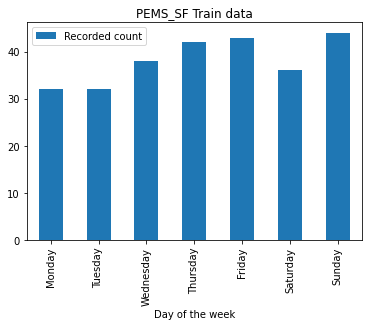

<Figure size 1440x360 with 0 Axes>

In [6]:
draw_class_equilibrium(train_y_pems_sf, PEMS_SF_CLASS_VALUES_MAPPER, PEMS_SF_CLASSES_CATEGORY, "Recorded count", "PEMS_SF Train data")

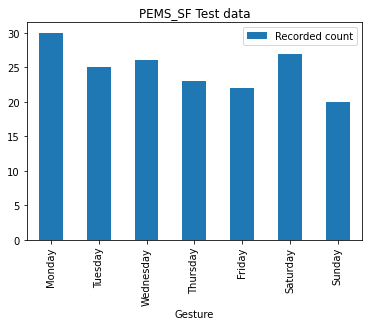

<Figure size 1440x360 with 0 Axes>

In [7]:
draw_class_equilibrium(test_y_pems_sf, PEMS_SF_CLASS_VALUES_MAPPER, U_WAVE_CLASSES_CATEGORY, "Recorded count", "PEMS_SF Test data")

##### #1.1.2 U_WAVE_GESTURE
This dataset is has an even class distribution both in train and test subsets.

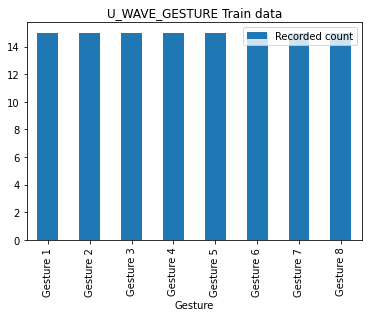

<Figure size 1440x360 with 0 Axes>

In [8]:
draw_class_equilibrium(train_y_u_wave_gesture, U_WAVE_GESTURE_CLASS_VALUES_MAPPER, U_WAVE_CLASSES_CATEGORY, "Recorded count", "U_WAVE_GESTURE Train data")

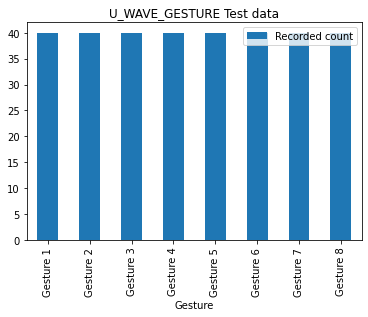

<Figure size 1440x360 with 0 Axes>

In [9]:
draw_class_equilibrium(test_y_u_wave_gesture, U_WAVE_GESTURE_CLASS_VALUES_MAPPER, U_WAVE_CLASSES_CATEGORY, "Recorded count", "U_WAVE_GESTURE Test data")


### #1.2 U Wave Gesture axis evolution

##### #1.2.1 Random example for each gesture

In [10]:
def plot_gesture_evolution(chosen_row: pd.Series, class_label_value: str) -> None:
    x_asis_evolution = chosen_row[0]
    y_asis_evolution = chosen_row[1]
    z_asis_evolution = chosen_row[2]
    
    number_of_points = len(x_asis_evolution)
    plot_x_axis = np.linspace(0, number_of_points - 1, number_of_points)
    plt.plot(plot_x_axis, x_asis_evolution, label="X Asis evolution")
    plt.plot(plot_x_axis, y_asis_evolution, label="Y Asis evolution", linestyle=":")
    plt.plot(plot_x_axis, z_asis_evolution, label="Z Asis evolution", linestyle="--")
    plt.xlabel("Time units")
    plt.ylabel("Position")
    plt.title(class_label_value)
    plt.legend()
    plt.figure(figsize=(20, 5))
    plt.show()


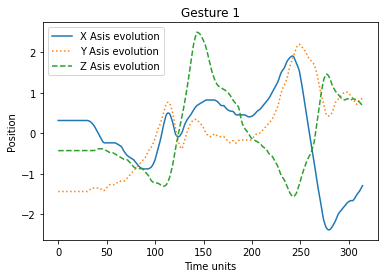

<Figure size 1440x360 with 0 Axes>

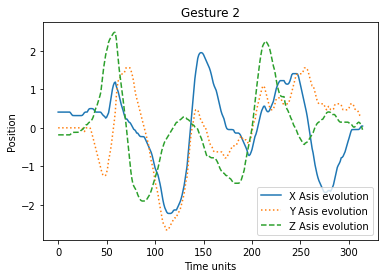

<Figure size 1440x360 with 0 Axes>

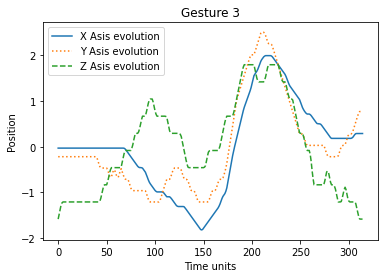

<Figure size 1440x360 with 0 Axes>

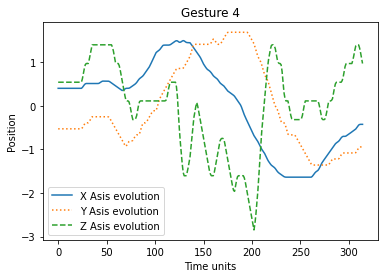

<Figure size 1440x360 with 0 Axes>

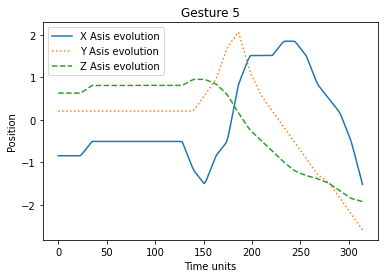

<Figure size 1440x360 with 0 Axes>

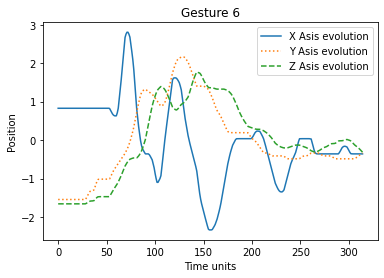

<Figure size 1440x360 with 0 Axes>

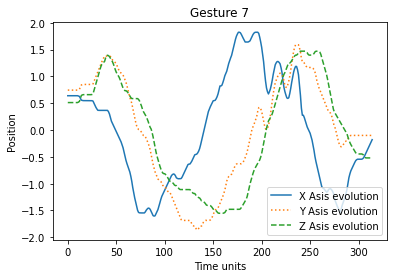

<Figure size 1440x360 with 0 Axes>

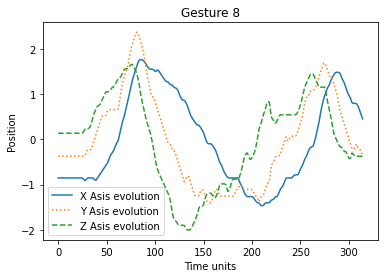

<Figure size 1440x360 with 0 Axes>

In [11]:
for class_label_key in U_WAVE_GESTURE_CLASS_VALUES_MAPPER.keys():
    class_label_value = U_WAVE_GESTURE_CLASS_VALUES_MAPPER[class_label_key]
    current_gesture_data_frame = u_wave_gesture_train_translated.loc[u_wave_gesture_train_translated[U_WAVE_CLASSES_CATEGORY] == class_label_value]
    number_of_rows = len(current_gesture_data_frame.index)
    chosen_index = random.randint(0, number_of_rows - 1)
    chosen_row =  current_gesture_data_frame.iloc[chosen_index]
    plot_gesture_evolution(chosen_row, class_label_value)

##### #1.2.2 Axis evolution distribution per gesture

In [12]:
def plot_axis_evolution(data_frame: pd.DataFrame, column_name: str, classes_category: str) -> None:
    axis_data_frame = data_frame[[column_name, classes_category]]
    
    grouped_by_class= dict()
    for index in range(0, len(axis_data_frame.index)):
        current_row = axis_data_frame.iloc[index]
        values_array = current_row[0]
        correct_class = current_row[1]
        value_for_current_series = values_array.mean()

        if correct_class in grouped_by_class:
            old_array = grouped_by_class[correct_class]
            old_array.append(value_for_current_series)
        else:
            grouped_by_class[correct_class] = [value_for_current_series]

    for correct_class in grouped_by_class:
        correct_class_values_distribution = grouped_by_class[correct_class]
        length = len(correct_class_values_distribution)
        plt.bar([0.0] + correct_class_values_distribution, ["0.0"] + ([correct_class] * length), \
            color=U_WAVE_GESTURE_CLASS_VALUES_TO_COLOR_MAPPER[correct_class], width=(10e-8 * 5), alpha=0.3, label=correct_class)

    plt.xlabel("Mean values")
    plt.ylabel(classes_category)
    plt.legend()
    plt.title("Axis distribution for {} per gesture".format(column_name))
    plt.figure(figsize=(20, 5))
    plt.show()

def plot_all_axis_evolution(data_frame: pd.DataFrame, classes_category: str) -> None:
    plot_axis_evolution(data_frame, "dim_0", classes_category)
    plot_axis_evolution(data_frame, "dim_1", classes_category)
    plot_axis_evolution(data_frame, "dim_2", classes_category)

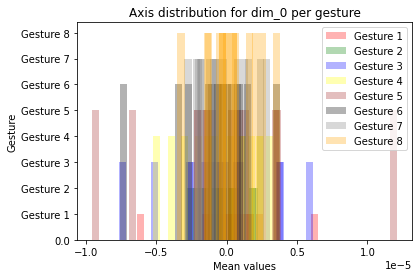

<Figure size 1440x360 with 0 Axes>

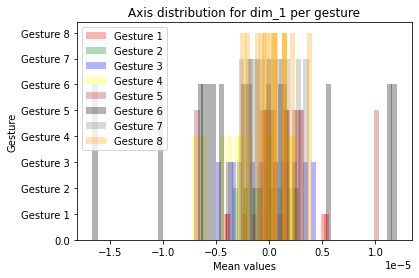

<Figure size 1440x360 with 0 Axes>

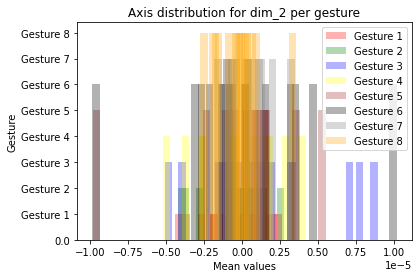

<Figure size 1440x360 with 0 Axes>

In [13]:
plot_all_axis_evolution(u_wave_gesture_train_translated, U_WAVE_CLASSES_CATEGORY)

### #1.3 PEMS-SF Analysis

#### #1.3.1 Best sensors deviation week days

In [14]:
NUMBER_OF_TOP_SENSORS = 10
NUMBER_OF_DAYS = 8

def standard_deviation(element):
    if type(element) == pd.Series:
        return element.std()
    else:
        return element

def fetch_days(data_frame: pd.DataFrame, class_labels: list, classes_category: str):
    new_data_frame = pd.DataFrame(columns=data_frame.columns)
    for class_label in class_labels:
        for days_index in range(0, NUMBER_OF_DAYS): 
            row = data_frame.loc[data_frame[classes_category] == class_label].iloc[days_index]
            new_data_frame.loc[len(new_data_frame.index)] = row
    
    random_row = data_frame.iloc[random.randint(0, len(data_frame.index))] 
    new_data_frame.loc[len(new_data_frame.index)] = random_row

    return new_data_frame

def find_top_sensors_by_std_sum_desc(data_frame : pd.DataFrame, sensors_columns: list) -> list:
    data_frame = data_frame.applymap(standard_deviation)
    sensor_ordered_array = []
    for sensor_column in sensors_columns:
        sensor_standard_deviations = data_frame[sensor_column]
        sensor_sum = sensor_standard_deviations.sum()
        sensor_ordered_array.append((sensor_column, sensor_sum))
    
    sensor_ordered_array.sort(key=lambda pair : pair[1], reverse=True)
    sensor_ordered_array = sensor_ordered_array[0: NUMBER_OF_TOP_SENSORS]
    chosen_sensors = list(map(lambda pair: pair[0], sensor_ordered_array))
    return chosen_sensors

def plot_occupation_rate_deviation_on_days(data_frame: pd.DataFrame, sensors: list, classes_category: str) -> None:
    data_frame = data_frame.applymap(standard_deviation)
    
    for chosen_sensor in sensors:
        sensor_data_frame = data_frame[[chosen_sensor, classes_category]]
        plt.figure(figsize=(20, 5))
        plt.title("Occupation rate variation for sensor {}".format(chosen_sensor))
        plt.xlabel(classes_category)
        plt.ylabel("Occupation rate")
        seaborn.boxplot(x = classes_category, y = chosen_sensor, data = sensor_data_frame)
        plt.show()


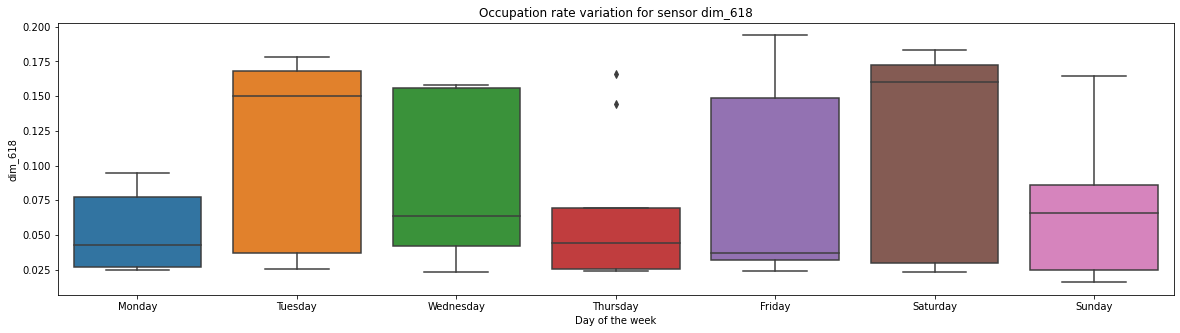

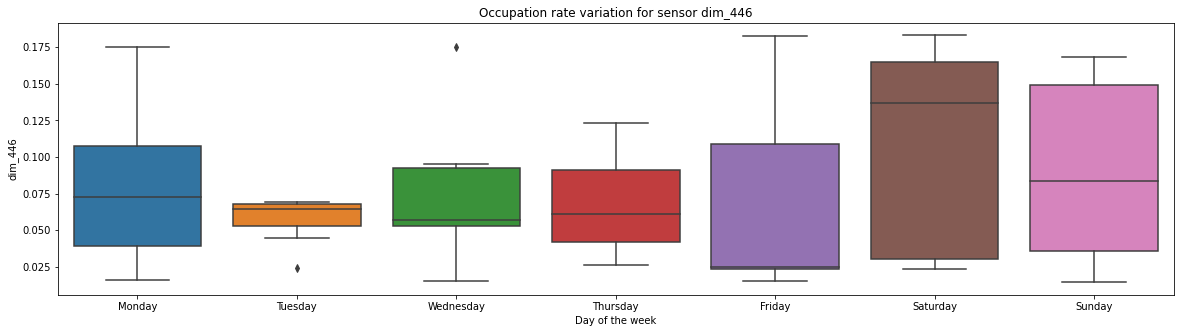

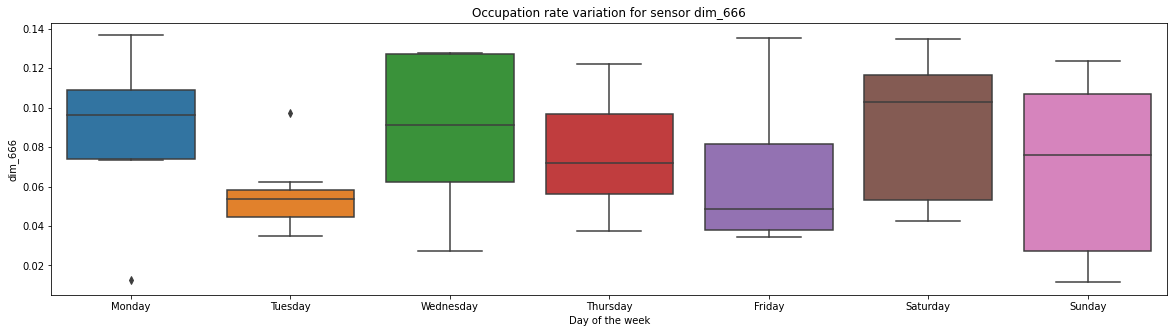

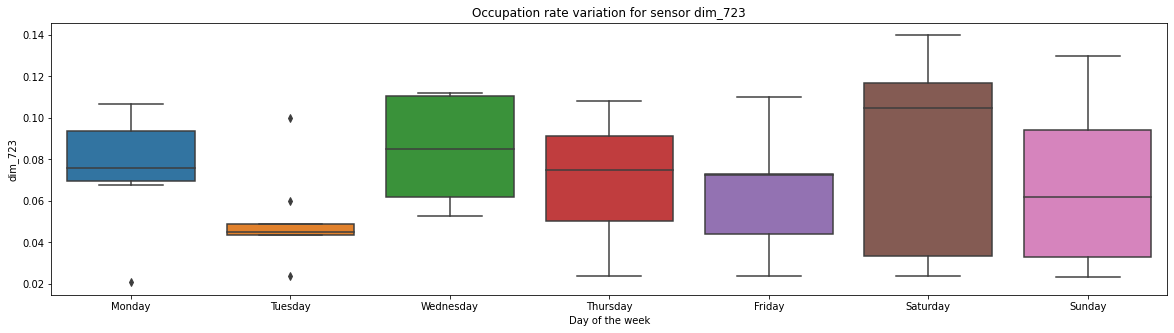

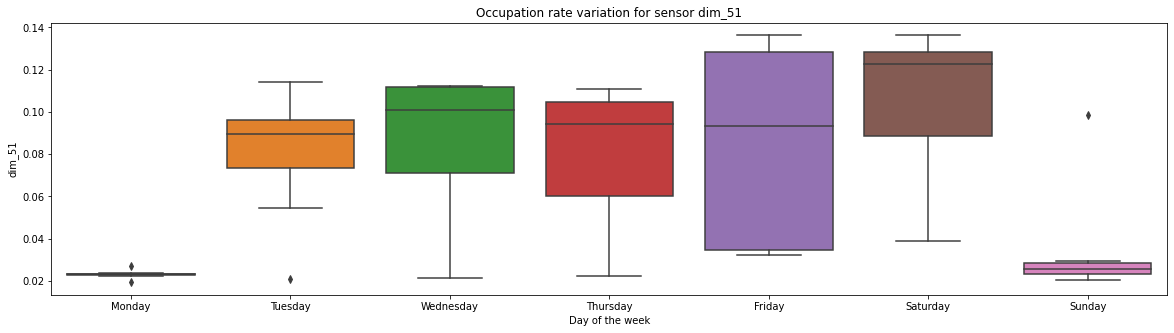

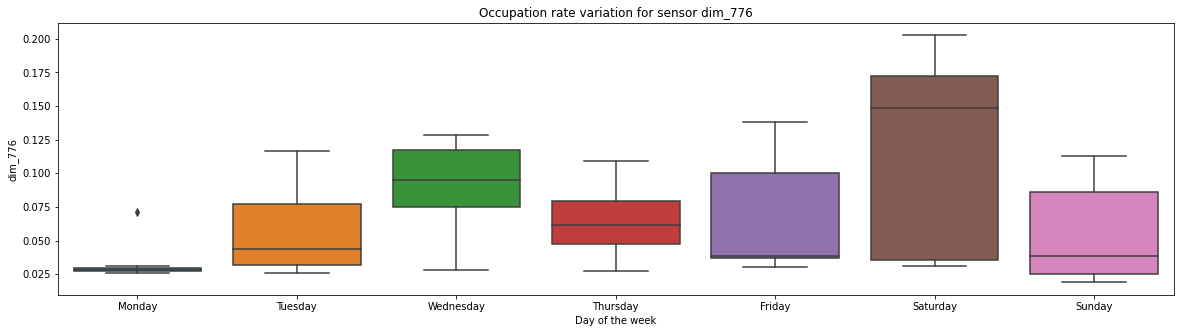

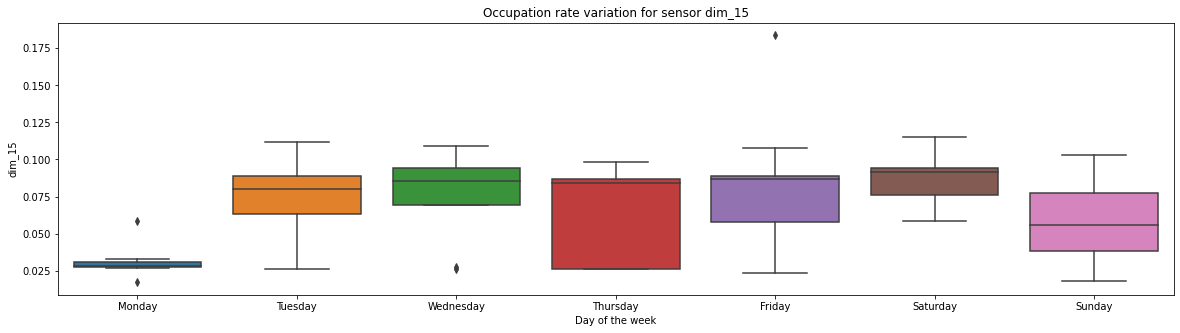

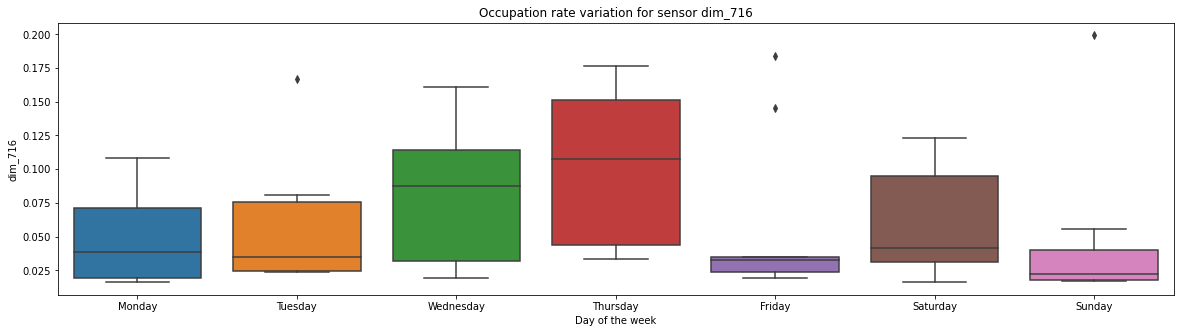

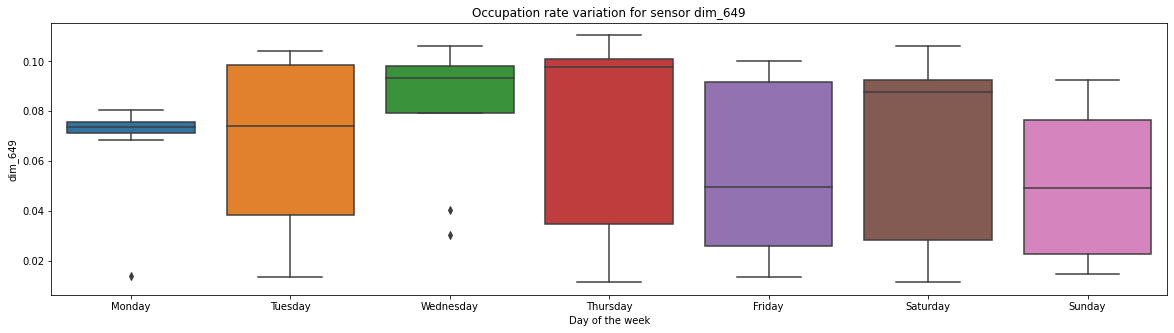

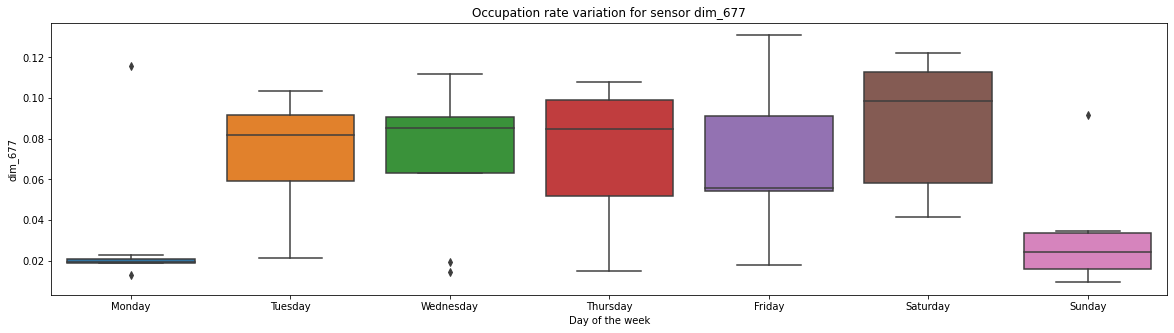

In [15]:
chosen_days_data_frame = fetch_days(pems_sf_train_translated, PEMS_SF_CLASS_VALUES_MAPPER.values(), PEMS_SF_CLASSES_CATEGORY)
chosen_sensors = find_top_sensors_by_std_sum_desc(chosen_days_data_frame, pems_sf_columns)
plot_occupation_rate_deviation_on_days(chosen_days_data_frame, chosen_sensors, PEMS_SF_CLASSES_CATEGORY)

#### #1.3.2 Best sensors occupation rate year evolution

In [16]:
def compute_mean_values_on_columns(data_frame: pd.DataFrame) -> pd.DataFrame:
    return data_frame.applymap(lambda x : x.mean())

def get_top_sensors_by_mean_values_std_desc(data_frame: pd.DataFrame, number_of_sensors: int):
    data_frame = compute_mean_values_on_columns(data_frame)
    return data_frame.std(axis = 0).sort_values(ascending = False)[0:number_of_sensors].index

In [17]:
top_sensors = get_top_sensors_by_mean_values_std_desc(train_x_pems_sf, NUMBER_OF_TOP_SENSORS)
mean_data_frame = compute_mean_values_on_columns(train_x_pems_sf)

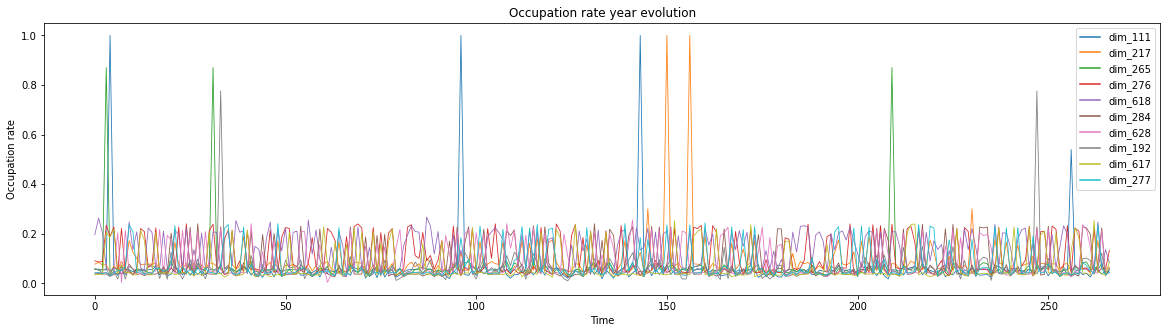

In [18]:
plt.figure(figsize=(20, 5))
plt.title("Occupation rate year evolution")
plt.xlabel("Time")
plt.ylabel("Occupation rate")
seaborn.lineplot(data = mean_data_frame[top_sensors], dashes=False, lw=0.8)
plt.show()

# #2 Feature Extraction & classic algorithms

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

## #2.1 PEMS-SF

In [20]:
from scipy.signal import argrelextrema

def get_number_of_peaks(values: pd.Series, peaks_neighbourhood_percentage: float = 0.02) -> int:
    return argrelextrema(np.array(values), np.less_equal, order = int(len(values) * peaks_neighbourhood_percentage) )[0].size 

def prepare_pems_sf_data_set(data_set: pd.DataFrame):
    new_data_set = pd.DataFrame()
    for column_name in data_set.columns:
        current_column_data_set = data_set[column_name]
        new_data_set["mean_" + column_name] = current_column_data_set.apply(lambda x : x.mean())
        new_data_set["number_of_mins_" + column_name] = current_column_data_set.apply(lambda x : get_number_of_peaks(x))
        new_data_set["std_" + column_name] = current_column_data_set.apply(lambda x : x.std())
        new_data_set["max_" + column_name] = current_column_data_set.apply(lambda x : x.max())
        new_data_set["min_" + column_name] = current_column_data_set.apply(lambda x : x.min())
        new_data_set["difference_" + column_name] = current_column_data_set.apply(lambda x : abs(x.max() - x.min()))
        new_data_set["25_" + column_name] = current_column_data_set.apply(lambda x : np.percentile(x, 25))
        new_data_set["50_" + column_name] = current_column_data_set.apply(lambda x : np.percentile(x, 50))
        new_data_set["75_" + column_name] = current_column_data_set.apply(lambda x : np.percentile(x, 75))
        new_data_set["skew_" + column_name] = current_column_data_set.apply(lambda x : abs(x.skew()))
        new_data_set["kurtosis_" + column_name] = current_column_data_set.apply(lambda x : abs(x.kurtosis()))
    return new_data_set

In [21]:
train_x_pems_sf_expanded = prepare_pems_sf_data_set(train_x_pems_sf)
test_x_pems_sf_expanded = prepare_pems_sf_data_set(test_x_pems_sf)

/tmp/ipykernel_18047/1601199759.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data_set["number_of_mins_" + column_name] = current_column_data_set.apply(lambda x : get_number_of_peaks(x))
/tmp/ipykernel_18047/1601199759.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data_set["std_" + column_name] = current_column_data_set.apply(lambda x : x.std())
/tmp/ipykernel_18047/1601199759.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, chi2

def select_features(X: pd.DataFrame, y : pd.DataFrame, variance_threshold_percentage = 0.6, percentile=25) -> pd.DataFrame:
    X = VarianceThreshold(threshold=(variance_threshold_percentage * (1 - variance_threshold_percentage))).fit_transform(X)
    X = SelectPercentile(chi2, percentile=percentile).fit_transform(X, y)
    return pd.DataFrame(X)

In [ ]:
train_rows = len(train_x_pems_sf_expanded)
test_rows = len(test_x_pems_sf_expanded)

full_X_features_expanded = pd.concat([train_x_pems_sf_expanded, test_x_pems_sf_expanded])
full_Y = np.concatenate((train_y_pems_sf, test_y_pems_sf))

print("Number of features after expansion = ", len(full_X_features_expanded.columns))
full_X_features_filtered = select_features(full_X_features_expanded, full_Y)
print("Number of features after selection = ", len(full_X_features_filtered[0]))

train_x_pems_sf_filtered = full_X_features_filtered[0: train_rows]
test_x_pems_sf_filtered = full_X_features_filtered[train_rows: len(full_X_features_expanded)]

Number of features after expansion =  10593
Number of features after selection =  440


In [ ]:
full_X_features_filtered = np.concatenate((train_x_pems_sf_filtered, test_x_pems_sf_filtered))

NameError: name 'np' is not defined

In [ ]:
############################################ RANDOM FOREST ############################################
parameters = {
    "max_depth": [5, 10, 15, 20],
    "n_estimators" : [10, 100, 200, 500],
    "min_samples_split" : [2, 5, 7]
}
grid_search = GridSearchCV(RandomForestClassifier(), parameters)

# result = grid_search.fit(train_x_pems_sf_filtered, train_y_pems_sf)
result = grid_search.fit(full_X_features_filtered, full_Y)

best_parameters_random_forest = grid_search.best_params_
print("best_parameters_random_forest", best_parameters_random_forest)

best_parameters {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
best_score 0.9954545454545455


In [ ]:
randomForestClassifier = RandomForestClassifier(**best_parameters_random_forest)
randomForestClassifier.fit(train_x_pems_sf_filtered, train_y_pems_sf)
y_predict = randomForestClassifier.predict(test_x_pems_sf_filtered)
accuracy_score(test_y_pems_sf, y_predict)

0.9479768786127167

In [ ]:
############################################ SVM ############################################
parameters = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
     'C': [1, 2, 3, 4, 5],
     'degree': [1, 2, 3, 4, 5],
     'gamma' : ['scale', 'auto']
}

grid_search = GridSearchCV(SVC(), parameters)

result = grid_search.fit(train_x_pems_sf_filtered, train_y_pems_sf)
# result = grid_search.fit(full_X_features_filtered, full_Y)

best_parameters_svm = grid_search.best_params_
print("best_parameters_svm", best_parameters_svm)

svm = SVC(**best_parameters_svm)
svm.fit(train_x_pems_sf_filtered, train_y_pems_sf)
y_predict = svm.predict(test_x_pems_sf_filtered)
accuracy_score(test_y_pems_sf, y_predict)

best_parameters {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}


0.7456647398843931

In [ ]:
############################################ GradientBoosted Trees ############################################
parameters = {
    'max_depth': [3, 6, 10, 20],
    'n_estimators': [5, 100, 500, 1000],
    'learning_rate': [0.05, 0.1, 0.2, 0.5],
}

grid_search = GridSearchCV(XGBClassifier(), parameters)
result = grid_search.fit(train_x_pems_sf_filtered.fillna(0.0,inplace=True), train_y_pems_sf)
# result = grid_search.fit(full_X_features_filtered, full_Y)

best_parameters_xgb = grid_search.best_params_
print("best_parameters_xgb", best_parameters_xgb)

xgbClassifier = XGBClassifier(**best_parameters_xgb)
xgbClassifier.fit(train_x_pems_sf_filtered, train_y_pems_sf)
y_predict = xgbClassifier.predict(test_x_pems_sf_filtered)
accuracy_score(test_y_pems_sf, y_predict)

TypeError: Expected sequence or array-like, got <class 'NoneType'>

In [ ]:
train_x_pems_sf_filtered.fillna(0.0,inplace=True)
train_x_pems_sf_filtered.replace()

,0,1,2,3,4,5,6,7,8,9,...,698,699,700,701,702,703,704,705,706,707
0,0.203343,1.299592,1.670467,4.004982,1.314587,1.609323,2.177161,4.681298,1.952719,4.001610,...,0.810503,1.505568,3.853862,6.701433,1.182277,0.423427,1.325332,8.721167,1.254549,2.989177
1,1.586966,6.685780,1.396854,3.294024,1.294870,1.338186,2.560896,6.762534,1.745884,2.782589,...,0.410937,2.068450,3.966324,5.625299,1.083939,0.589049,1.353534,2.991923,15.853697,0.370507
2,0.243970,1.286009,0.604139,0.402639,1.606058,2.057604,2.297314,4.812614,1.996213,3.535702,...,0.396934,1.617651,2.611906,2.387988,0.787478,0.796034,0.622707,3.044049,5.004453,0.923403
3,3.463938,15.143542,2.869017,8.294724,1.563789,2.158126,2.133509,3.841083,1.854405,2.993582,...,2.157530,0.008382,0.972505,0.510007,0.965616,0.697745,1.115335,0.463916,0.901167,0.961779
4,0.033151,1.627570,0.146739,1.557618,0.399028,0.658131,0.054465,1.380619,0.088923,1.578615,...,1.555320,0.179907,1.591684,1.325003,1.588541,1.409092,1.182041,0.774606,1.379596,1.596936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,0.123778,1.061668,0.591051,0.496748,1.576786,1.778748,2.701472,9.440278,0.873059,1.486961,...,17.892454,0.092898,1.277495,0.861736,1.164990,11.501115,0.100376,5.335542,0.671012,7.388911
263,0.343223,1.344521,2.992867,9.297344,2.393305,7.498269,2.117976,3.613869,2.031399,3.830518,...,1.320886,0.142781,1.119867,2.592832,6.954131,1.052519,1.047197,1.275247,0.545668,6.807491
264,3.108888,19.359914,3.121399,14.281533,0.275850,1.365602,0.394404,0.603304,1.294083,1.100181,...,0.296851,0.982191,2.147010,0.720204,2.492166,5.918695,1.114809,1.012757,1.198588,1.217814
265,0.095893,1.358623,0.517400,1.028696,0.570054,0.345318,0.174294,1.319389,0.211893,1.379911,...,1.363834,0.228087,1.184060,1.286378,1.275510,1.206281,1.282390,4.867753,1.349379,0.112916
